# Large Language Models

## **Session 4-3:** Using Local LLMs to generate Simulation Code

As previously shown, we will use the GPT4ALL implementation to create the simulation model of a spring-damper system. 


In [34]:
from gpt4all import GPT4All
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import torch # only used to check if cuda is availible
import time
from LLMHelperFunctions import CheckOutputLLM # helper function

flagSmall = False

if flagSmall: 
    # approx 2.4GB
    repo_id = 'microsoft/phi-3-mini-4k-instruct-gguf'
    filename =  "Phi-3-mini-4k-instruct-q4.gguf"
else: 
    repo_id = "bartowski/phi-4-GGUF"
    filename = "phi-4-Q4_K_S.gguf"
    
modelPath = hf_hub_download(repo_id=repo_id, filename=filename) 
try: 
    model = GPT4All(modelPath, device='cuda')
    print('running model on GPU')
except: 
    model = GPT4All(modelPath, device='cpu')
    print('running model on CPU')

running model on GPU


### Input Formatting
For the used Phi-4 model the prompt format  
```<|im_start|>system<|im_sep|>{system_prompt}<|im_end|>```   
```<|im_start|>user<|im_sep|>{prompt}<|im_end|> ```   
```<|im_start|>assistant<|im_sep|> ```   
is used (see also [here](https://huggingface.co/bartowski/phi-4-GGUF)). The LLM continues as the assistent and stops at the token <|im_end|>. 

In [35]:
# Open the file in read mode and save its content to the variable 'data'
with open("Prompt_Osci.txt", "r") as file:
    prompt = file.read()
print('prompt:\n', prompt)

system_prompt = 'You are an engineer and specialized in mechanics.'
strTask = prompt
prompt_formatted = f"<|im_start|>system<|im_sep|>{system_prompt}<|im_end|><|im_start|>user<|im_sep|>{strTask}<|im_end|><|im_start|>assistant<|im_sep|>"


prompt:
 Create Python code for a 2-mass spring-damper with m1=1kg, m2=5kg, k1=k2=1600N/m and d1=d2=8Nm/s using scipy. The initial displacement and Velocity shall be 0 for both masses, but on the second mass a force F=100*np.sin(t) should act. Plot the displacements of both masses. 
Create only the code and no additional output. 


In [36]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-4')
tokens = tokenizer.encode(prompt_formatted, add_special_tokens=False) # Tokenize the prompt
num_tokens = len(tokens)
print("Number of input tokens:", num_tokens)
print('prompt formatted: ', prompt_formatted)

Number of input tokens: 115
prompt formatted:  <|im_start|>system<|im_sep|>You are an engineer and specialized in mechanics.<|im_end|><|im_start|>user<|im_sep|>Create Python code for a 2-mass spring-damper with m1=1kg, m2=5kg, k1=k2=1600N/m and d1=d2=8Nm/s using scipy. The initial displacement and Velocity shall be 0 for both masses, but on the second mass a force F=100*np.sin(t) should act. Plot the displacements of both masses. 
Create only the code and no additional output. <|im_end|><|im_start|>assistant<|im_sep|>


### Code Generation

Now, the actual simulation code is created by the language model. This might take a bit.  
If the local model does not have good performance, you can also use an online interface as e.g., [chatpgt](https://chatgpt.com/) or [gemini](https://gemini.google.com). 



In [47]:
t1 = time.time()
print('start generation... ')
strOutput = model.generate(prompt_formatted, max_tokens=int(2048), temp=1.0)
tokensOut = tokenizer.encode(strOutput, add_special_tokens=False)
dt = time.time() - t1
print('Number of output tokens: {}. \nIt took {}s  | {} tokens/s'.format(len(tokensOut), dt, len(tokensOut)/dt))
print(strOutput)


start generation... 
Number of output tokens: 495. 
It took 81.56538391113281s  | 6.068750936540835 tokens/s
```python
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
m1, m2 = 1.0, 5.0  # masses in kg
k1, k2 = 1600.0, 1600.0  # spring constants in N/m
d1, d2 = 8.0, 8.0  # damping coefficients in Ns/m

# System of differential equations
def system(t, y):
    x1, v1, x2, v2 = y
    
    # Forces on the masses
    F_external = 100 * np.sin(t)
    
    # Equations derived from Newton's second law for each mass
    a1 = (-(d1 + d2) * v1 + d2 * v2 - k1 * x1 - k2 * (x1 - x2)) / m1
    a2 = (d2 * v1 - d2 * v2 + F_external + k2 * (x1 - x2)) / m2
    
    return [v1, a1, v2, a2]

# Initial conditions: [displacement of mass 1, velocity of mass 1, displacement of mass 2, velocity of mass 2]
y0 = [0.0, 0.0, 0.0, 0.0]

# Time span for the simulation
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

# Solve the system using solve_ivp from sci

### Code Extraction

    
The typical models tend to provide explanations for the code not only as comments but also before and after. The code tags __```__ help to locate the code as part of the output, but not all models might use them. Alternatively, one could also instruct the model to use e.g., HTML tags. 


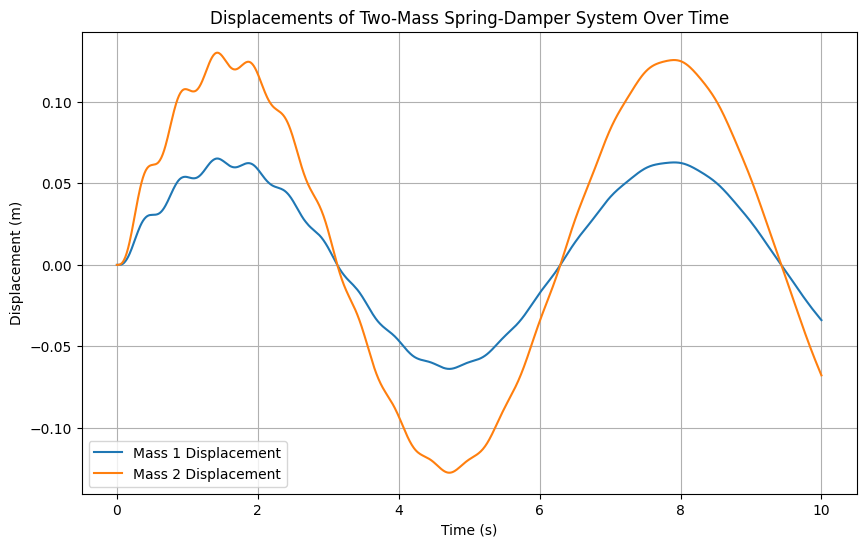

In [46]:
pythonCode = strOutput.split('```python')[1].split('```')[0] # extract code from output

# Be careful: code execution is a potential safety risk as it is directly executed and not reviewed. 
# To avoid (some) issues, the CheckOutputLLM helper function checks if some 
CheckOutputLLM(pythonCode)
for myString in problematicStrings: 
    if myString in pythonCode: 
        raise ValueError('forbidden string was in pythonCode. Check code before execution!')
exec(pythonCode) 
